# Project Title: Passengers Count (Hourly Predictions)

Project Goal and Description: The aim of this project is to predict new passengers overtime using TLC Trip Record Data
Source Link: https://www.nyc.gov/site/tlc/about/tlc-trip-record-data.page https://www.nyc.gov/assets/tlc/downloads/pdf/data_dictionary_trip_records_yellow.pdf https://www.nyc.gov/assets/tlc/downloads/pdf/trip_record_user_guide.pdf

# Import Modules

In [1]:
import os
import sys
import warnings
from credentials import *
sys.path.append(sys_path_ds)
import IPython
import datetime
import numpy as np
import pandas as pd
import seaborn as sns
import IPython.display
from PIL import Image
import tensorflow as tf
from tensorflow import keras
from Queries.ml import *
import matplotlib as mpl
import matplotlib.pyplot as plt
from urllib.request import urlopen
from sqlalchemy import text, create_engine

# Options and Settings

In [2]:
rnd_seed = tf.random.set_seed(1234)
warnings.simplefilter('ignore')
mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

# Load Image

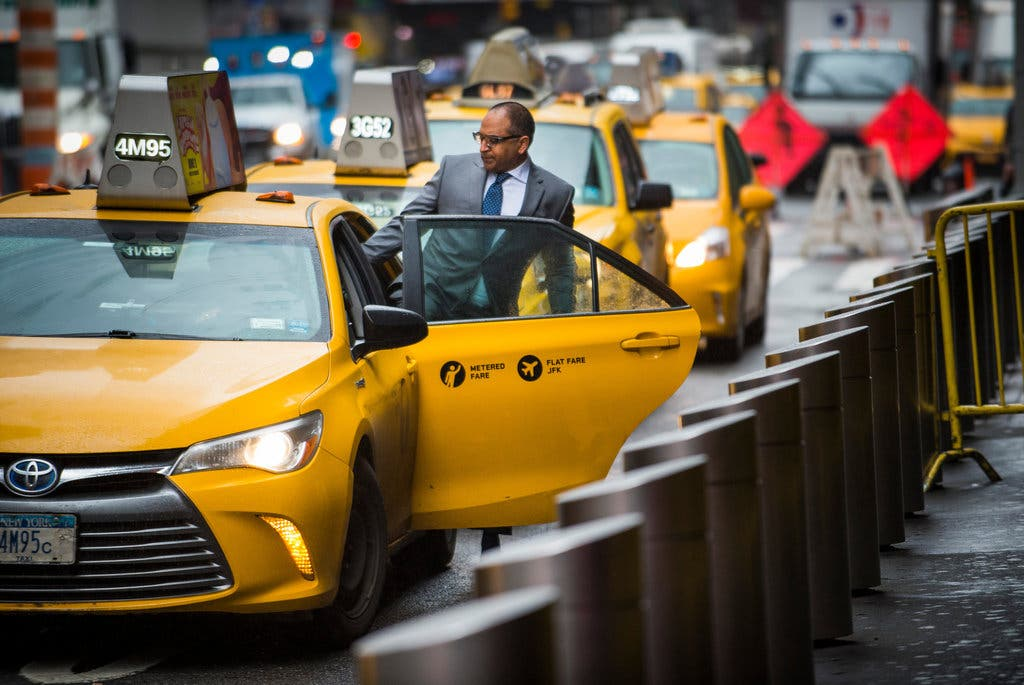

In [3]:
image_url = 'https://static01.nyt.com/images/2017/06/07/nyregion/07TAXI1/07TAXI1-jumbo.jpg?quality=75&auto=webp'
Image.open(urlopen(image_url))

# Helper Functions

In [4]:
def get_data(query: str)->pd.DataFrame:
    '''
    Fetches data from Postgresql database and returns a pandas dataframe

    '''
    engine = create_engine(f'{driver_postgres}://{user_postgres}:{password_postgres}@{hostname_postgres}/{pg_db_yt}')
    
    with engine.connect() as conn:
        df = pd.read_sql(sql=text(query), con=conn)
        conn.close()
    return df



def plot_line(data: pd.DataFrame, date: str,  rule: str, rot: int = 45, xlabel: str = None, ylabel: str = None, title: str = None, **kwargs):
    '''
    Plots a line chart of passenger count overtime

    data: pd.DataFrame
        pandas dataframe

    date: pd.Timestamp
        date column to set as index
    
    rule: ruleDateOffset, Timedelta or str
        https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.resample.html
    
    '''
    return data.set_index(date).resample(rule).count().plot(xlabel=xlabel, ylabel=ylabel, title=title, rot=rot, **kwargs)



def plot_violin(data: pd.DataFrame, t: str = None, xlabel: str = None, ylabel: str = None, title: str = None, **kwargs):
    '''
    Draw a combination of boxplot and kernel density estimate.

    data: DataFrame, array, or list of arrays, optional
        Dataset for plotting.

    t: str
       Main plot title
    
    '''
    fig, ax = plt.subplots()
    fig.suptitle(t=t)

    sns.violinplot(data=data, **kwargs)
    ax.set(xlabel=xlabel, ylabel=ylabel, title=title)

    return plot_violin



def train_test_split(data, train: float = 0.8, test = None, **kwargs) -> tuple:
    '''
    Split a dataset into a left half and a right half (e.g. train / test).

    Args:
      data: A tf.data.Dataset object, or a list/tuple of arrays with the same length.

      train: it signifies the fraction of the data to pack in the left dataset. (Train Set)

      test. it signifies the fraction of the data to pack in the right dataset. (Test Set)

      Returns:
        A tuple of two tf.data.Dataset objects: the left and right splits

        https://www.tensorflow.org/api_docs/python/tf/keras/utils/split_dataset

    '''
    
    left_ds, right_ds = tf.keras.utils.split_dataset(dataset=np.array(data), left_size=train, right_size=test, seed=rnd_seed, **kwargs)

    print(f'Train Length: {int(left_ds.cardinality())}')
    print(f'Test Length: {int(right_ds.cardinality())}')

    train_data = list(left_ds.as_numpy_iterator())
    train_data = [train_data[i][1:] for i in range(len(train_data))]

    train_labels = list(left_ds.as_numpy_iterator())
    train_labels = pd.Series([train_labels[i][0] for i in range(len(train_labels))])

    test_data = list(right_ds.as_numpy_iterator())
    test_data = [test_data[i][1:] for i in range(len(test_data))]

    test_labels = list(right_ds.as_numpy_iterator())
    test_labels = pd.Series([test_labels[i][0] for i in range(len(test_labels))])

    return train_data, train_labels, test_data, test_labels



def normalize(data, feat_cols: list[str], axis: int = -1, order: int = 2):
    '''
    Normalizes a Numpy array.

    Args:
        data: Numpy array to normalize.
        feat_cols: Feature columns to normalize
        axis: axis along which to normalize.
        order: Normalization order (e.g. order=2 for L2 norm).

    Returns:
        A normalized copy of the array.
        
    '''
    feature_cols = data[feat_cols].columns
    features = data[feature_cols]

    return tf.keras.utils.normalize(features, axis=axis, order=order)



def train_val_test_split(df: pd.DataFrame) -> pd.DataFrame:
    '''
    Split dataset into training, validation and test data

    Parameters

    df: pd.DataFrame
      Pandas Dataframe

    Returns:
      Pandas Dataframe

    '''
    n = len(df)

    num_features = df.shape

    df_train = df[:int(n*0.7)]
    df_val = df[int(n*0.7):int(n*0.9)]
    df_test = df[int(n*0.9):]

    print(f'num_train_samples: {df_train.shape},\
        num_val_samples: {df_val.shape},\
        num_test_samples: {df_test.shape},\
        num_features: {num_features}'
     )
    
    return df_train, df_val, df_test


def normalize(data, feat_cols: list[str], axis: int = -1, order: int = 2):
    '''
    Normalizes a Numpy array.

    Args:
        data: Numpy array to normalize.
        feat_cols: Feature columns to normalize
        axis: axis along which to normalize.
        order: Normalization order (e.g. order=2 for L2 norm).

    Returns:
        A normalized copy of the array.

    https://www.tensorflow.org/api_docs/python/tf/keras/utils/normalize
        
    '''
    feature_cols = data[feat_cols].columns
    features = data[feature_cols]

    return tf.keras.utils.normalize(features, axis=axis, order=order)


def window_dataset(features, targets, sequence_length: int = 1, sampling_rate: int = 1, seed: int = rnd_seed, **kwargs):
    '''
    Creates a dataset of sliding windows over a timeseries provided as array

    Args:
     features: Numpy array or eager tensor

     targets: Targets corresponding to timesteps in features

     sequence_length: Length of the output sequences (in number of timesteps)

     sampling_rate: Period between successive individual timesteps

     seed: Optional int; random seed for shuffling

     https://www.tensorflow.org/api_docs/python/tf/keras/utils/timeseries_dataset_from_array

    '''
    dataset = keras.utils.timeseries_dataset_from_array(
                                                         data=features,
                                                         targets=targets,
                                                         sequence_length=sequence_length,
                                                         sampling_rate=sampling_rate,
                                                         seed=seed,
                                                         **kwargs
                                                       )
    
    for samples, targets in dataset:
      print(f'batch_size: {samples.shape[0]}')
      print(f'input_data: {samples.shape[1]}')
      print(f'num_features: {samples.shape[2]}')
      print('\n')
      print('samples shape:', samples.shape)
      print('\n')
      print('targets shape:', targets.shape)
      break

    return np.float32(samples), np.float32(targets)


def model_pipeline(layers, optimizer, loss, metrics, x, y, validation_data, model_name, epochs: int = 10,  **kwargs):
  '''
  Pipeline for building, compiling and model fitting
    
  Args:
    layers: Optional list of layers to add to the model.
      optimizer: String (name of optimizer) or optimizer instance. See
      tf.keras.optimizers.
    loss: Loss function. May be a string (name of loss function), or
      a tf.keras.losses.Loss instance. See tf.keras.losses.
    metrics: List of metrics to be evaluated by the model during training and testing.
    x: Input data. 
    y: Output data.
    validation_data: data to evaluate trained model on
    model_name: name of the best saved model
    epochs: Number of epochs to train the model.
    use_multiprocessing: If True, use process-based threading.     

    Returns:
      A History object. Its History.history attribute is a record of training loss values and metrics values at successive epochs, 
      as well as validation loss values and validation metrics values 
        
    '''
  model = keras.Sequential(layers=layers, **kwargs)
  model.compile(optimizer=optimizer, loss=loss, metrics=metrics, **kwargs)
  history = model.fit(x=x, y=y, validation_data=validation_data, epochs=epochs, callbacks=[keras.callbacks.ModelCheckpoint(f'{model_name}', 
                        save_best_only=True)], use_multiprocessing=True)
    
  return pd.DataFrame(history.history)


def plot_model_history(df: pd.DataFrame, metric_cols: list[str], **kwargs):
    '''
    
    Plot model results

    df: pd.DataFrame

    metric_cols: list of strings

    '''
    return df[metric_cols].plot(**kwargs)



def evaluate_test_model(x, y, name: str) -> pd.DataFrame:
    '''
    Evaluates best model performance on test data

    Parameters

    x: pd.DataFrame
        pandas dataframe
    y: pd.Series
        pandas series
    name: str
        name of best saved model

    Returns:
        A dataframe of model results on test data

    '''
    best_model = keras.models.load_model(f'{name}')

    print(f'Test MAE: {best_model.evaluate(x, y)[1]:.2f}')
    print(f'Test RMSE: {best_model.evaluate(x, y)[2]:.2f}')
    
    cols = ['y_true', 'y_pred', 'mae', 'rmse']

    predictions = best_model.predict(x)
    print('\n')
    print(f'y_true_shape: {y.shape} <==> y_pred_shape: {predictions.shape}')
    print('\n')
    pred_as_arr = [predictions[_] for _ in range(len(predictions))]
    n_arr = len(pred_as_arr[0])

    results = pd.DataFrame(pred_as_arr[0])
    results['y_true'] = y[:n_arr]
    results['mae'] = best_model.evaluate(x, y)[1] 
    results['rmse'] = best_model.evaluate(x, y)[2]

    model_results = results.rename({0: 'y_pred'}, axis=1).reindex(cols, axis=1)
    model_results[['y_true', 'y_pred']] = abs(round(model_results[['y_true', 'y_pred']]))
    model_results[['mae', 'rmse']] = round(model_results[['mae', 'rmse']], 2)
    
    good_pred = len(model_results.loc[model_results['y_true'] == model_results['y_pred']])
    bad_pred = len(model_results.loc[model_results['y_true'] != model_results['y_pred']])
    total_preds = np.sum([good_pred, bad_pred])

    pct_correct = round(np.divide(good_pred, total_preds) * 100, 2)
    pct_wrong = round(np.divide(bad_pred, total_preds) * 100, 2)
    print('\n')
    print(f'From a total test data of {total_preds}, {good_pred} were correctly predicted thus {pct_correct}% whiles {bad_pred} were wrongly predicted representing {pct_wrong}%')

    return model_results

# Extract Data

Sample data on an hourly basis

In [5]:
df = get_data(query1)
df = df\
      .set_index('tpep_pickup_datetime')\
      .resample('H')\
      .count()\
      .reset_index()   

In [6]:
df.head()

,tpep_pickup_datetime,passenger_count
0,2001-01-01 00:00:00,2
1,2001-01-01 01:00:00,0
2,2001-01-01 02:00:00,0
3,2001-01-01 03:00:00,0
4,2001-01-01 04:00:00,0


In [7]:
df.tail()

,tpep_pickup_datetime,passenger_count
195112,2023-04-05 16:00:00,1
195113,2023-04-05 17:00:00,3
195114,2023-04-05 18:00:00,3
195115,2023-04-05 19:00:00,1
195116,2023-04-05 20:00:00,2


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 195117 entries, 0 to 195116
Data columns (total 2 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   tpep_pickup_datetime  195117 non-null  datetime64[ns]
 1   passenger_count       195117 non-null  int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 3.0 MB


In [9]:
round(df.describe().transpose())

,count,mean,std,min,25%,50%,75%,max
passenger_count,195117.0,21.0,274.0,0.0,0.0,0.0,0.0,5133.0


<Axes: title={'center': 'Yearly Passenger Count OverTime'}, xlabel='Year', ylabel='Passenger Count'>

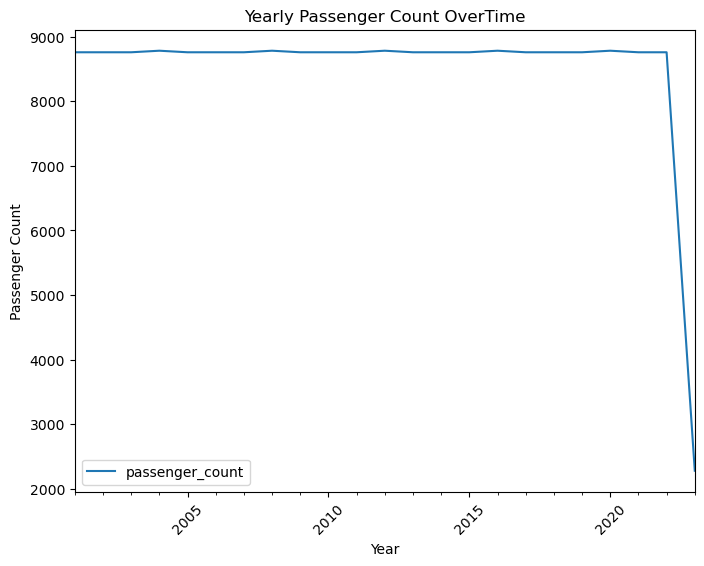

In [10]:
plot_line(df, date='tpep_pickup_datetime', rule='Y', xlabel='Year', ylabel='Passenger Count', title='Yearly Passenger Count OverTime')

<Axes: title={'center': 'Quarterly Passenger Count OverTime'}, xlabel='Year', ylabel='Passenger Count'>

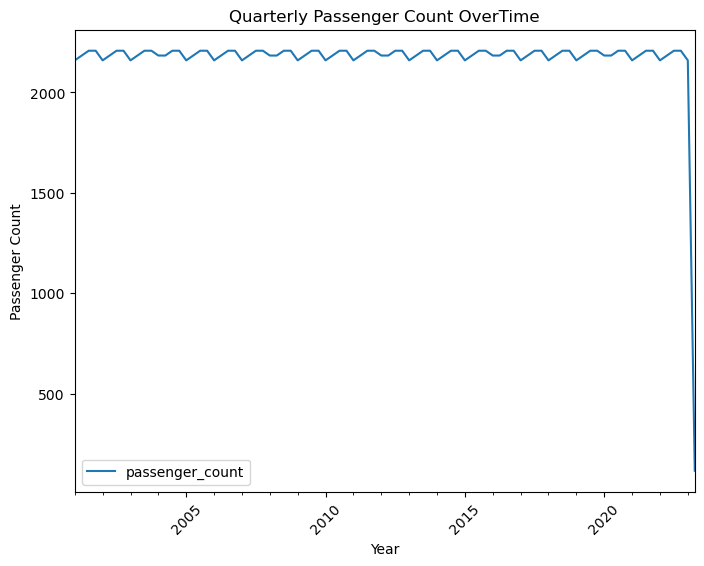

In [11]:
plot_line(df, date='tpep_pickup_datetime', rule='Q', xlabel='Year', ylabel='Passenger Count', title='Quarterly Passenger Count OverTime')

<Axes: title={'center': 'Monthly Passenger Count OverTime'}, xlabel='Year', ylabel='Passenger_count'>

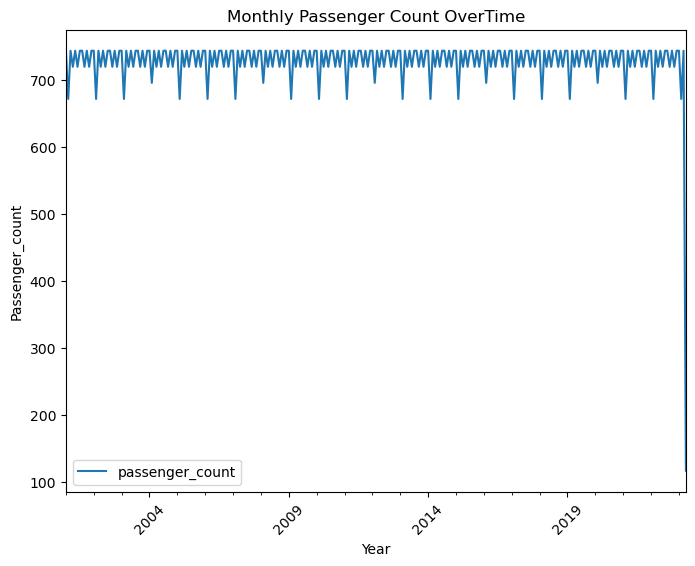

In [12]:
plot_line(df, date='tpep_pickup_datetime', rule='M', xlabel='Year', ylabel='Passenger_count', title='Monthly Passenger Count OverTime')

# Feature Engineering

Transform Timestamp Data

In [13]:
# convert the date and time when the meter was engaged to seconds
timestamp_s = df['tpep_pickup_datetime'].map(pd.Timestamp.timestamp)

# for subsequent stages of transformation, since taxi data deals with seasonality, it clearly has daily and yearly periodicity.
# calculate total seconds within a day and year
secs_in_day = 24 * 60 * 60
secs_in_yr = np.dot(365.2425, secs_in_day)


df['day_sin'] = np.sin(timestamp_s * (2 * np.pi / secs_in_day))
df['day_cos'] = np.cos(timestamp_s * (2 * np.pi / secs_in_day))
df['year_sin'] = np.sin(timestamp_s * (2 * np.pi / secs_in_yr))
df['year_cos'] = np.cos(timestamp_s * (2 * np.pi / secs_in_yr))

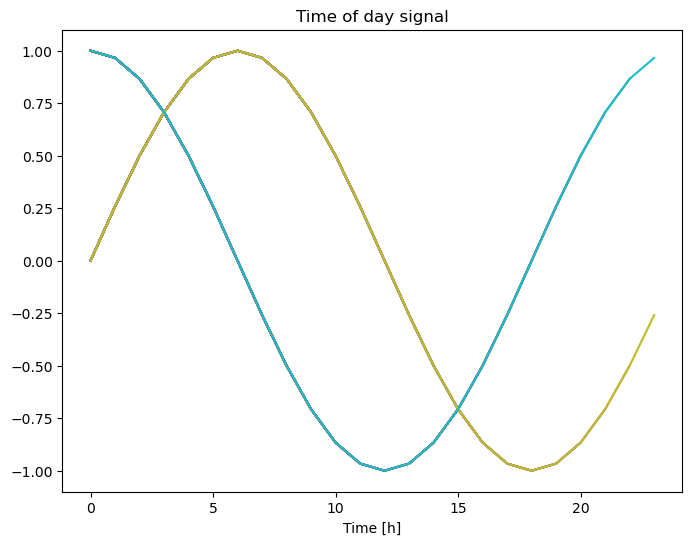

In [14]:
fig, ax = plt.subplots()

for _ in range(25):
    plt.plot(np.array(df['day_sin'])[:_])
    plt.plot(np.array(df['day_cos'])[:_])
    ax.set(title='Time of day signal', xlabel='Time [h]')

# Split Data

In [15]:
# training, validation, and test sets will comprise of (70%, 20%, 10%) of the entire data.
# randomly shuffling the data before splitting is not implemented in this case for two reasons
# - It ensures that slicing the data into windows of consecutive samples is still possible.
# - It ensures that the validation/test results are more realistic, being evaluated on the data collected after the model was trained.

train_df, val_df, test_df = train_val_test_split(df)

num_train_samples: (136581, 6),        num_val_samples: (39024, 6),        num_test_samples: (19512, 6),        num_features: (195117, 6)


# Data Normalization

In [16]:
feature_cols = ['day_sin', 'day_cos', 'year_sin', 'year_cos']
target_col = ['passenger_count']

X_train = normalize(train_df, feature_cols)
X_val = normalize(val_df, feature_cols)
X_test = normalize(test_df, feature_cols)

y_train = train_df[target_col]
y_val = val_df[target_col]
y_test = test_df[target_col]

<function __main__.plot_violin(data: pandas.core.frame.DataFrame, t: str = None, xlabel: str = None, ylabel: str = None, title: str = None, **kwargs)>

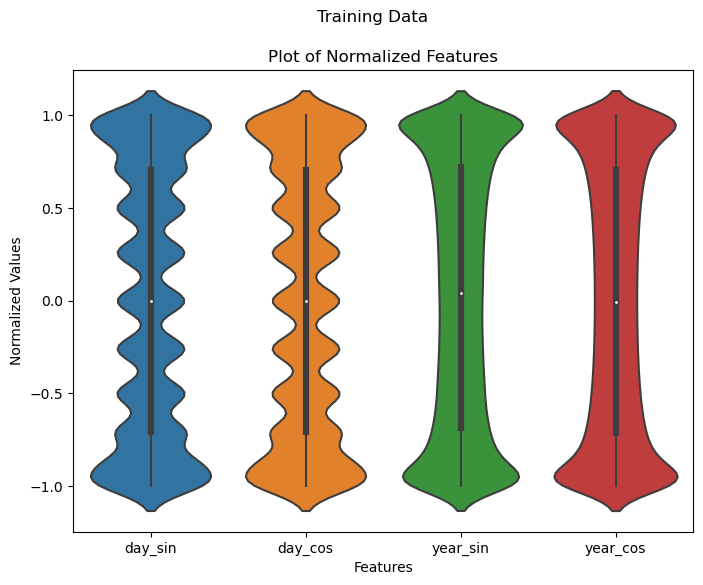

In [17]:
plot_violin(train_df[feature_cols], 'Training Data', 'Features', 'Normalized Values', 'Plot of Normalized Features')

<function __main__.plot_violin(data: pandas.core.frame.DataFrame, t: str = None, xlabel: str = None, ylabel: str = None, title: str = None, **kwargs)>

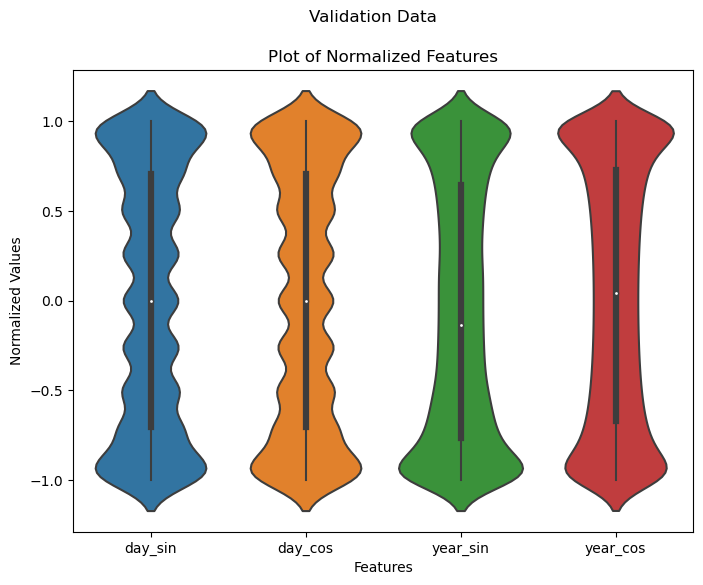

In [18]:
plot_violin(val_df[feature_cols], 'Validation Data', 'Features', 'Normalized Values', 'Plot of Normalized Features')

<function __main__.plot_violin(data: pandas.core.frame.DataFrame, t: str = None, xlabel: str = None, ylabel: str = None, title: str = None, **kwargs)>

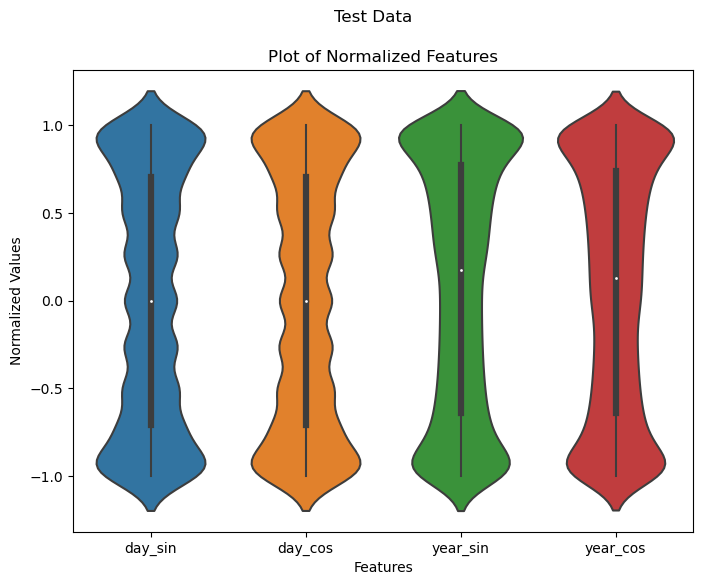

In [19]:
plot_violin(test_df[feature_cols], 'Test Data', 'Features', 'Normalized Values', 'Plot of Normalized Features')

# Data Windowing

In [20]:
# using past 3 days data to predict next 24 hours data (24hrs in a day * 3days)
# sampling rate of 1 because data is already sampled on an hourly basis

batch_size = 128
seq_length = np.dot(24, 3)

# generate training data on the fly (it would be wasteful to explicitly allocate memory for every sample)
x_train_samp, y_train_samp = window_dataset(X_train, y_train, sequence_length=seq_length, seed=rnd_seed, batch_size=batch_size) 

# generate corresponding data for validation
x_val_samp, y_val_samp = window_dataset(X_val, y_val, sequence_length=seq_length, seed=rnd_seed, batch_size=batch_size) 

# generate corresponding data for testing
x_test_samp, y_test_samp = window_dataset(X_test, y_test, sequence_length=seq_length, seed=rnd_seed, batch_size=batch_size) 

batch_size: 128
input_data: 72
num_features: 4


samples shape: (128, 72, 4)


targets shape: (128, 1)
batch_size: 128
input_data: 72
num_features: 4


samples shape: (128, 72, 4)


targets shape: (128, 1)
batch_size: 128
input_data: 72
num_features: 4


samples shape: (128, 72, 4)


targets shape: (128, 1)


# Data Modelling

Dense Model

In [21]:
dense_model_history = model_pipeline(
                                      layers=[
                                               keras.layers.Input(shape=(x_train_samp.shape[1], x_train_samp.shape[-1])),
                                               keras.layers.Dense(128, activation='relu'),
                                               keras.layers.Dropout(rate=0.50),
                                               keras.layers.Dense(64, activation='relu'),
                                               keras.layers.Dropout(rate=0.25),
                                               keras.layers.Dense(32, activation='relu'),
                                               keras.layers.Dropout(rate=0.1),
                                               keras.layers.Dense(1)
                                             ],
                                       optimizer=keras.optimizers.RMSprop(),
                                       loss=keras.losses.MeanSquaredError(),
                                       metrics=[keras.metrics.MeanAbsoluteError(), keras.metrics.RootMeanSquaredError()],
                                       x=x_train_samp,
                                       y=y_train_samp,
                                       validation_data=(x_val_samp, y_val_samp),
                                       model_name='passenger_count_dense.keras'
                                    )

Epoch 1/10
4/4 [==============================] - 1s 83ms/step - loss: 0.0495 - mean_absolute_error: 0.1007 - root_mean_squared_error: 0.2224 - val_loss: 1.5364e-04 - val_mean_absolute_error: 0.0102 - val_root_mean_squared_error: 0.0124
Epoch 2/10
4/4 [==============================] - 0s 20ms/step - loss: 0.0429 - mean_absolute_error: 0.0737 - root_mean_squared_error: 0.2072 - val_loss: 7.1153e-04 - val_mean_absolute_error: 0.0227 - val_root_mean_squared_error: 0.0267
Epoch 3/10
4/4 [==============================] - 0s 19ms/step - loss: 0.0423 - mean_absolute_error: 0.0737 - root_mean_squared_error: 0.2058 - val_loss: 2.9478e-04 - val_mean_absolute_error: 0.0134 - val_root_mean_squared_error: 0.0172
Epoch 4/10
4/4 [==============================] - 0s 19ms/step - loss: 0.0415 - mean_absolute_error: 0.0679 - root_mean_squared_error: 0.2037 - val_loss: 2.2819e-04 - val_mean_absolute_error: 0.0117 - val_root_mean_squared_error: 0.0151
Epoch 5/10
4/4 [==============================] - 0s

 Long Short Term Memory (LSTM)

In [22]:
lstm_model_history = model_pipeline(
                                      layers=[
                                               keras.layers.Input(shape=(x_train_samp.shape[1], x_train_samp.shape[-1])),
                                               keras.layers.LSTM(128, recurrent_dropout=0.5, return_sequences=True),
                                               keras.layers.LSTM(64, recurrent_dropout=0.25, return_sequences=True),
                                               keras.layers.LSTM(32, recurrent_dropout=0.1, return_sequences=True),
                                               keras.layers.Dense(1)
                                             ],
                                       optimizer=keras.optimizers.RMSprop(),
                                       loss=keras.losses.MeanSquaredError(),
                                       metrics=[keras.metrics.MeanAbsoluteError(), keras.metrics.RootMeanSquaredError()],
                                       x=x_train_samp,
                                       y=y_train_samp,
                                       validation_data=(x_val_samp, y_val_samp),
                                       model_name='passenger_count_lstm.keras'
                                    )

Epoch 1/10
4/4 [==============================] - 5s 398ms/step - loss: 0.0562 - mean_absolute_error: 0.0968 - root_mean_squared_error: 0.2370 - val_loss: 1.4751e-04 - val_mean_absolute_error: 0.0107 - val_root_mean_squared_error: 0.0121
Epoch 2/10
4/4 [==============================] - 1s 176ms/step - loss: 0.0392 - mean_absolute_error: 0.0295 - root_mean_squared_error: 0.1979 - val_loss: 4.0345e-05 - val_mean_absolute_error: 0.0057 - val_root_mean_squared_error: 0.0064
Epoch 3/10
4/4 [==============================] - 1s 159ms/step - loss: 0.0397 - mean_absolute_error: 0.0570 - root_mean_squared_error: 0.1993 - val_loss: 8.6801e-05 - val_mean_absolute_error: 0.0087 - val_root_mean_squared_error: 0.0093
Epoch 4/10
4/4 [==============================] - 1s 155ms/step - loss: 0.0390 - mean_absolute_error: 0.0461 - root_mean_squared_error: 0.1975 - val_loss: 1.7530e-04 - val_mean_absolute_error: 0.0125 - val_root_mean_squared_error: 0.0132
Epoch 5/10
4/4 [==============================] 

# Bidirectional RNN

In [23]:
BiRnn_model_history = model_pipeline(
                                      layers=[
                                               keras.layers.Input(shape=(x_train_samp.shape[1], x_train_samp.shape[-1])),
                                               keras.layers.Bidirectional(keras.layers.LSTM(128, recurrent_dropout=0.5, return_sequences=True)),
                                               keras.layers.Bidirectional(keras.layers.GRU(64,  recurrent_dropout=0.4, return_sequences=True)),
                                               keras.layers.Bidirectional(keras.layers.LSTM(32, recurrent_dropout=0.3, return_sequences=True)),
                                               keras.layers.Bidirectional(keras.layers.GRU(16, recurrent_dropout=0.2, return_sequences=True)),
                                               keras.layers.Dense(1)
                                             ],
                                       optimizer=keras.optimizers.RMSprop(),
                                       loss=keras.losses.MeanSquaredError(),
                                       metrics=[keras.metrics.MeanAbsoluteError(), keras.metrics.RootMeanSquaredError()],
                                       x=x_train_samp,
                                       y=y_train_samp,
                                       validation_data=(x_val_samp, y_val_samp),
                                       model_name='passenger_count_BiRnn.keras'
                                    )

Epoch 1/10
4/4 [==============================] - 15s 1s/step - loss: 0.1677 - mean_absolute_error: 0.2186 - root_mean_squared_error: 0.4095 - val_loss: 2.6491e-04 - val_mean_absolute_error: 0.0152 - val_root_mean_squared_error: 0.0163
Epoch 2/10
4/4 [==============================] - 3s 862ms/step - loss: 0.0389 - mean_absolute_error: 0.0314 - root_mean_squared_error: 0.1973 - val_loss: 3.4775e-04 - val_mean_absolute_error: 0.0171 - val_root_mean_squared_error: 0.0186
Epoch 3/10
4/4 [==============================] - 3s 843ms/step - loss: 0.0412 - mean_absolute_error: 0.0628 - root_mean_squared_error: 0.2030 - val_loss: 1.0744e-04 - val_mean_absolute_error: 0.0092 - val_root_mean_squared_error: 0.0104
Epoch 4/10
4/4 [==============================] - 3s 884ms/step - loss: 0.0391 - mean_absolute_error: 0.0485 - root_mean_squared_error: 0.1978 - val_loss: 1.5789e-04 - val_mean_absolute_error: 0.0114 - val_root_mean_squared_error: 0.0126
Epoch 5/10
4/4 [==============================] - 

# Plot Model History

<Axes: title={'center': 'Training and Validation RMSE (Dense Model)'}, xlabel='Epochs', ylabel='Root Mean Square Error'>

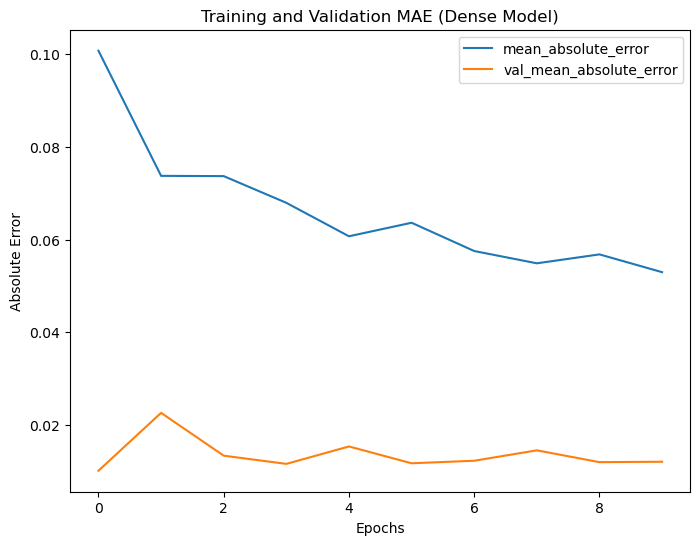

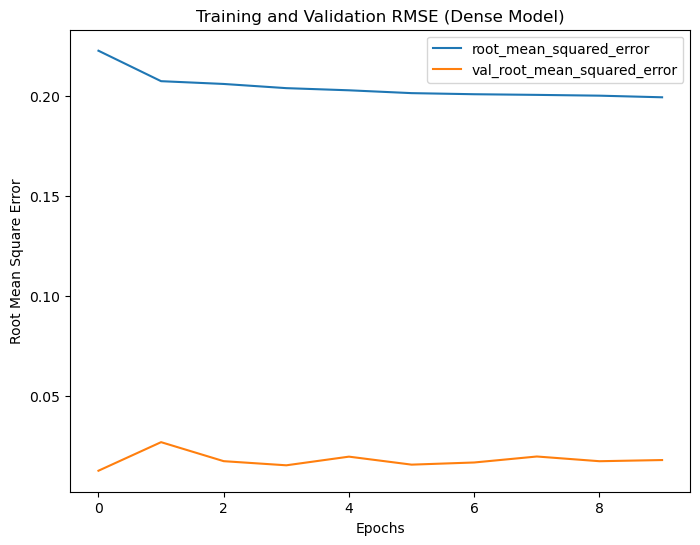

In [24]:
abs_error = ['mean_absolute_error', 'val_mean_absolute_error']
rmse_error = ['root_mean_squared_error', 'val_root_mean_squared_error']

plot_model_history(dense_model_history, abs_error, xlabel='Epochs', ylabel='Absolute Error', title='Training and Validation MAE (Dense Model)')
plot_model_history(dense_model_history, rmse_error, xlabel='Epochs', ylabel='Root Mean Square Error', title='Training and Validation RMSE (Dense Model)')

<Axes: title={'center': 'Training and Validation RMSE (LSTM Model)'}, xlabel='Epochs', ylabel='Root Mean Square error'>

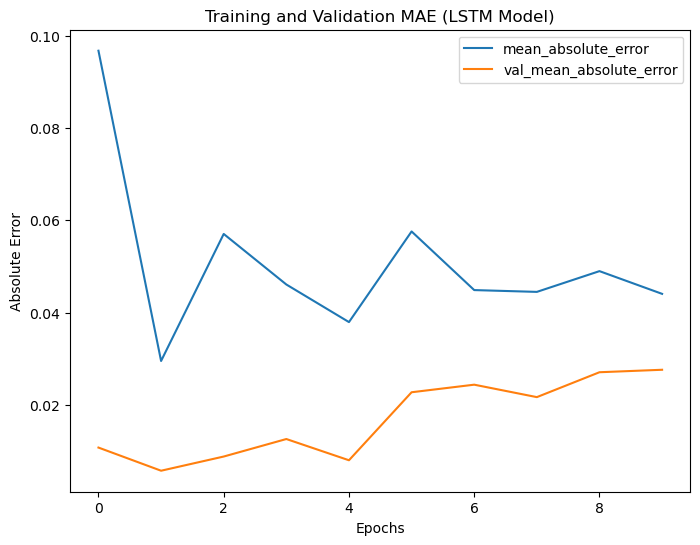

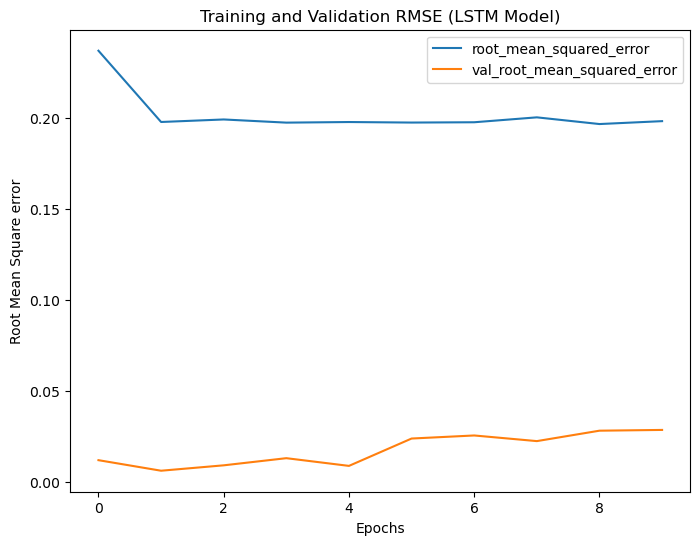

In [25]:
plot_model_history(lstm_model_history, abs_error, xlabel='Epochs', ylabel='Absolute Error', title='Training and Validation MAE (LSTM Model)')
plot_model_history(lstm_model_history, rmse_error, xlabel='Epochs', ylabel='Root Mean Square error', title='Training and Validation RMSE (LSTM Model)')

<Axes: title={'center': 'Training and Validation RMSE (BiRNN Model)'}, xlabel='Epochs', ylabel='Root Mean Square error'>

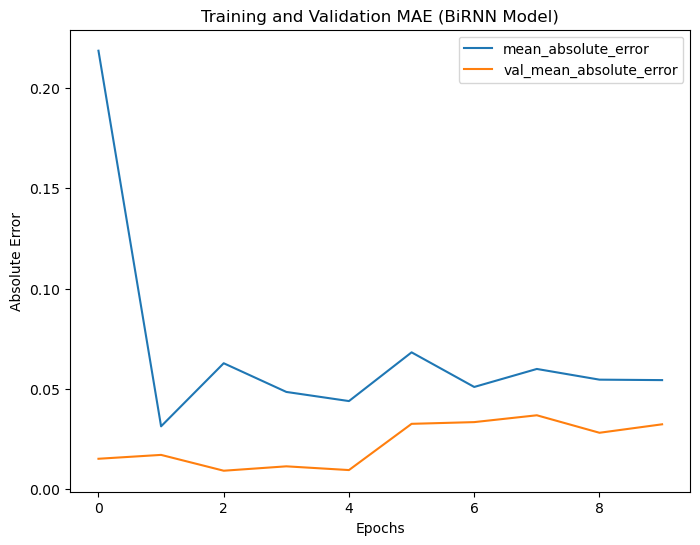

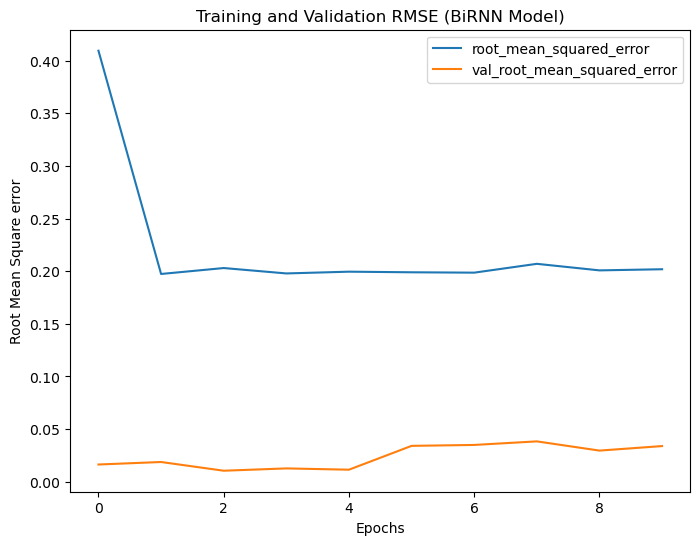

In [26]:
plot_model_history(BiRnn_model_history, abs_error, xlabel='Epochs', ylabel='Absolute Error', title='Training and Validation MAE (BiRNN Model)')
plot_model_history(BiRnn_model_history, rmse_error, xlabel='Epochs', ylabel='Root Mean Square error', title='Training and Validation RMSE (BiRNN Model)')

# Best Model Exploration

In [27]:
test_model_summary = evaluate_test_model(x_test_samp, y_test_samp, 'passenger_count_dense.keras')

4/4 [==============================] - 0s 6ms/step - loss: 1.8463e-04 - mean_absolute_error: 0.0111 - root_mean_squared_error: 0.0136
Test MAE: 0.01
4/4 [==============================] - 0s 5ms/step - loss: 1.8463e-04 - mean_absolute_error: 0.0111 - root_mean_squared_error: 0.0136
Test RMSE: 0.01
4/4 [==============================] - 0s 5ms/step


y_true_shape: (128, 1) <==> y_pred_shape: (128, 72, 1)


4/4 [==============================] - 0s 5ms/step - loss: 1.8463e-04 - mean_absolute_error: 0.0111 - root_mean_squared_error: 0.0136


From a total test data of 72, 72 were correctly predicted thus 100.0% whiles 0 were wrongly predicted representing 0.0%
